# 2Path LSTM Model for Stock Price Prediction

This repository hosts an innovative 2Path LSTM (Long Short-Term Memory) model designed to predict stock prices by leveraging historical data from two distinct pathways: a forward and a backward sequence processor. This dual-path approach enables the model to capture complex temporal patterns from both directions, enhancing its ability to understand and forecast future stock movements effectively.

## Model Architecture

The 2Path LSTM model, built using PyTorch, includes several key components:

- **Bidirectional LSTM Layers**: The model features two LSTM layers, one processing sequences in a forward direction and the other in a backward direction. This bidirectional approach allows the model to gather insights from the past and anticipate future trends more accurately.
- **Input Layer**: Receives input sequences of stock prices, where each sequence represents historical data leading up to a prediction point.
- **Output Layer**: A linear layer that consolidates the output from both LSTM paths and produces a single output value representing the predicted stock price for the next day.
- **Loss Function and Optimizer**: Utilizes Mean Squared Error (MSE) for loss calculation and Adam optimizer for adjusting weights during training, focusing on minimizing prediction errors.

## Forecasting Process

The process of forecasting with the 2Path LSTM model involves several steps:

1. **Data Preparation**: Stock price data is normalized using MinMax scaling to facilitate model training. The data is split into sequences that serve as inputs for both the forward and backward LSTM paths.

2. **Model Initialization**: The model is initialized with predefined settings such as learning rate, number of layers, and the dimensionality of each layer.

3. **Training Loop**: During each epoch of training, the model processes data through both LSTM paths, computes the loss, and updates the weights using backpropagation to reduce prediction error.

4. **Evaluation**: Post-training, the model's predictive accuracy is evaluated using a separate test dataset, which helps to assess its performance in real-world scenarios.

5. **Visualization**: The results, including predictions and actual stock prices, are visualized using Plotly. This visual representation highlights the model's efficacy and provides interactive insights into its predictive capabilities.

## Multiple Simulations

To ensure robustness and reliability, the model supports multiple training and prediction iterations. Each simulation involves retraining the model from scratch with the same or varied initial conditions to analyze consistency and variance in predictive performance.

## Usage Instructions

To deploy the 2Path LSTM model for stock price prediction:

1. **Load Data**: Import historical stock price data.
2. **Configure Model Parameters**: Set parameters like learning rate, number of layers, and neurons per layer.
3. **Prepare Data**: Normalize data and create input sequences.
4. **Instantiate Model**: Create an instance of the 2Path LSTM model.
5. **Train Model**: Execute the training process.
6. **Evaluate Performance**: Use the trained model to predict stock prices on the test dataset.
7. **Visualize Outcomes**: Plot actual versus predicted prices to assess the model visually.

## Requirements

- Python 3.x
- PyTorch
- NumPy
- Plotly

The 2Path LSTM model provides a sophisticated framework for financial analysts and investors to predict stock prices with enhanced accuracy. By analyzing historical data from dual perspectives, it offers a deeper understanding of market dynamics, aiding in better decision-making processes.

In [7]:
# !pip install yfinance tensorflow keras numpy matplotlib seaborn tqdm scikit-learn graphviz

In [60]:
from utils import *
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime
from datetime import timedelta
from tqdm import tqdm
import plotly.graph_objects as go


# Configure Modeling Parameters and Fetch Data

Enter a ticker and date range you would like to build the model on.  This model takes a a single ticker's data.  Also enter a training size for the proportion of the data you want to include in your training set vs. your test set.

In [123]:
# stock configs
ticker = ['TSLA']
start_date = '2015-04-01'
end_date = '2024-04-05'

# model configs
train_size = 0.8

In [4]:
# Data Fetching
data = fetch_stock_data(ticker, start_date, end_date)[ticker[0]]
data.reset_index(drop=False, inplace=True)
data['Date'] = pd.to_datetime(data['Date']).dt.tz_localize(None)

print(data.shape)
included_days = len(data)
data.head()

(2268, 8)


,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2015-04-01,12.580000,12.820000,12.403333,12.506000,56919000,0.0,0.0
1,2015-04-02,12.682000,12.882000,12.666667,12.733333,75156000,0.0,0.0
2,2015-04-06,13.200000,13.850000,13.166667,13.540000,186837000,0.0,0.0
3,2015-04-07,13.500667,13.670667,13.409333,13.550000,65218500,0.0,0.0
4,2015-04-08,13.880000,14.060000,13.724667,13.844667,94546500,0.0,0.0


# Model Implementation

Below we implement the model, first we separate the data into a train-test split.  For this LSTM model, we will leverage continuous windows of time for training and test data.


In [119]:
scaler = MinMaxScaler()
minmax = scaler.fit(data.iloc[:, 4:5].astype('float32')) # Close index
df_log = minmax.transform(data.iloc[:, 4:5].astype('float32')) # Close index
df_log = pd.DataFrame(df_log)
df_log.head()

,0
0,0.007313
1,0.007881
2,0.009895
3,0.009920
4,0.010656


In [124]:
simulation_size = 5
lookback = 30
train_len = int(included_days * train_size)
test_len = included_days - train_len

df_train = df_log.iloc[:train_len]
df_test = df_log.iloc[train_len:]


def create_dataset(X, look_back=1):
    dataX, dataY = [], []
    for i in range(len(X)-look_back):
        a = X[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(X[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

lookback = 30  # this variable was previously defined but not used in your example
X_train, y_train = create_dataset(df_train.values, lookback)
X_test, y_test = create_dataset(df_test.values, lookback)

# Adjust for LSTM input shape
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [125]:
class Model(nn.Module):
    def __init__(self, learning_rate, num_layers, size, size_layer, output_size, forget_bias=0.1):
        super(Model, self).__init__()
        self.num_layers = num_layers
        self.size_layer = size_layer
        self.output_size = output_size
        
        self.lstm_forward = nn.LSTM(size, size_layer, num_layers, batch_first=True, dropout=1-forget_bias)
        self.lstm_backward = nn.LSTM(size, size_layer, num_layers, batch_first=True, dropout=1-forget_bias)
        
        self.linear = nn.Linear(size_layer, output_size)
        self.loss_fn = nn.MSELoss()
        self.optimizer = optim.Adam(self.parameters(), lr=learning_rate)

    def forward(self, x_forward, x_backward, hidden_forward, hidden_backward):
        out_forward, _ = self.lstm_forward(x_forward, hidden_forward)
        out_backward, _ = self.lstm_backward(x_backward, hidden_backward)
        
        out = out_backward - out_forward
        out = self.linear(out[:, -1, :])  # Using the last output for prediction
        
        return out

    def init_hidden(self, batch_size):
        # Returns initial hidden state for the LSTMs
        return (Variable(torch.zeros(self.num_layers, batch_size, self.size_layer)),
                Variable(torch.zeros(self.num_layers, batch_size, self.size_layer)))

def calculate_accuracy(real, predict):
    real = torch.tensor(real) + 1
    predict = torch.tensor(predict) + 1
    percentage = 1 - torch.sqrt(torch.mean(torch.pow((real - predict) / real, 2)))
    return percentage.item() * 100

In [110]:
def anchor(signal, weight):
    buffer = []
    last = signal[0]
    for i in signal:
        smoothed_val = last * weight + (1 - weight) * i
        buffer.append(smoothed_val)
        last = smoothed_val
    return buffer

In [111]:
num_layers = 1
size_layer = 128
timestamp = 5
epoch = 20
dropout_rate = 0.8
future_day = 60
learning_rate = 0.01

In [112]:
def forecast(df_train, df_test):
    model = Model(0.01, 1, df_train.shape[1], 128, df_train.shape[1], 0.8)
    model.train()

    for epoch in range(20):  # Training for a few epochs
        total_loss, total_acc = [], []
        for i in range(0, df_train.shape[0] - 1, 5):  # `timestamp` is assumed to be 5
            index = min(i + 5, df_train.shape[0] - 1)
            batch_x_forward = torch.tensor(df_train.iloc[i:index, :].values[None, :, :], dtype=torch.float32)
            batch_x_backward = torch.tensor(np.flip(df_train.iloc[i:index, :].values, axis=0).copy()[None, :, :], dtype=torch.float32)
            batch_y = torch.tensor(df_train.iloc[i+1:index+1, :].values, dtype=torch.float32)
            hidden_forward = model.init_hidden(1)
            hidden_backward = model.init_hidden(1)
            model.optimizer.zero_grad()
            outputs = model(batch_x_forward, batch_x_backward, hidden_forward, hidden_backward)
            loss = model.loss_fn(outputs, batch_y)
            loss.backward()
            model.optimizer.step()
            total_loss.append(loss.item())
            total_acc.append(calculate_accuracy(batch_y[:, 0].numpy(), outputs[:, 0].detach().numpy()))
        print(f'Epoch {epoch}, Loss: {np.mean(total_loss)}, Accuracy: {np.mean(total_acc)}')

        
    model.eval()  # Switch to evaluation mode
    with torch.no_grad():
        # Predicting the test set
        test_x_forward = torch.tensor(df_test.values[None, :, :], dtype=torch.float32)
        test_x_backward = torch.tensor(np.flip(df_test.values, axis=0).copy()[None, :, :], dtype=torch.float32)
        hidden_forward = model.init_hidden(1)
        hidden_backward = model.init_hidden(1)
        test_pred = model(test_x_forward, test_x_backward, hidden_forward, hidden_backward)
    
    return test_pred.squeeze().numpy()

In [132]:
model = Model(learning_rate=0.01, num_layers=1, size=1, size_layer=128, output_size=1, forget_bias=0.1)
model.train()

# Training loop
n_epochs = 30
for epoch in range(n_epochs):
    model.optimizer.zero_grad()
    
    # Prepare data due to negative stride error
    x_forward = torch.tensor(X_train, dtype=torch.float32)
    x_backward = torch.tensor(np.copy(X_train[:, ::-1, :]), dtype=torch.float32)  # Make a copy here

    
    hidden_forward = model.init_hidden(X_train.shape[0])
    hidden_backward = model.init_hidden(X_train.shape[0])
    
    # Forward pass
    outputs = model(x_forward, x_backward, hidden_forward, hidden_backward)
    loss = model.loss_fn(outputs, torch.tensor(y_train, dtype=torch.float32).unsqueeze(-1))
    loss.backward()
    model.optimizer.step()
    
    if epoch % 5 == 0:
        print(f'Epoch {epoch} Loss: {loss.item()}')

# Evaluation
model.eval()
with torch.no_grad():
    # Prepare data due to negative stride error
    hidden_forward = model.init_hidden(X_test.shape[0])
    hidden_backward = model.init_hidden(X_test.shape[0])
    
    # Ensure to make a copy of the reversed array to avoid negative strides
    x_test_forward = torch.tensor(X_test, dtype=torch.float32)
    x_test_backward = torch.tensor(np.copy(X_test[:, ::-1, :]), dtype=torch.float32)
    
    test_predictions = model(x_test_forward, x_test_backward, hidden_forward, hidden_backward)
    test_loss = model.loss_fn(test_predictions, torch.tensor(y_test, dtype=torch.float32).unsqueeze(-1))
    print(f'Test Loss: {test_loss.item()}')

    # Calculate accuracy if applicable
    accuracy = calculate_accuracy(y_test, test_predictions.numpy().flatten())
    print(f'Accuracy: {accuracy}%')


Epoch 0 Loss: 0.0720202848315239
Epoch 5 Loss: 0.05364932119846344
Epoch 10 Loss: 0.002902650274336338
Epoch 15 Loss: 0.0029364461079239845
Epoch 20 Loss: 0.0034404376056045294
Epoch 25 Loss: 0.0019635113421827555
Test Loss: 0.002111626323312521
Accuracy: 96.94675207138062%


In [136]:
def run_model_iterations(n_iterations, X_train, y_train, X_test):
    predictions = []
    for _ in range(n_iterations):
        # Initialize the model
        model = Model(learning_rate=0.01, num_layers=1, size=1, size_layer=128, output_size=1, forget_bias=0.1)
        model.train()
        
        # Training
        for epoch in range(20):
            hidden_forward = model.init_hidden(X_train.shape[0])
            hidden_backward = model.init_hidden(X_train.shape[0])
            x_forward = torch.tensor(X_train, dtype=torch.float32)
            x_backward = torch.tensor(np.copy(X_train[:, ::-1, :]), dtype=torch.float32)
            
            model.optimizer.zero_grad()
            outputs = model(x_forward, x_backward, hidden_forward, hidden_backward)
            loss = model.loss_fn(outputs, torch.tensor(y_train, dtype=torch.float32).unsqueeze(-1))
            loss.backward()
            model.optimizer.step()
        
        # Evaluation
        model.eval()
        with torch.no_grad():
            hidden_forward = model.init_hidden(X_test.shape[0])
            hidden_backward = model.init_hidden(X_test.shape[0])
            x_test_forward = torch.tensor(X_test, dtype=torch.float32)
            x_test_backward = torch.tensor(np.copy(X_test[:, ::-1, :]), dtype=torch.float32)
            outputs = model(x_test_forward, x_test_backward, hidden_forward, hidden_backward)
        
        predictions.append(outputs.numpy().flatten())
    
    return predictions


In [137]:
# Run the model multiple times
n_iterations = 5
model_predictions = run_model_iterations(n_iterations, X_train, y_train, X_test)

# Load actual data (reshape if necessary)
actual_data = y_test.flatten()

In [141]:
# Dates for the X-axis (assuming you have a 'Date' column in your original data)
dates = pd.date_range(start=start_date, periods=len(y_test), freq='D')  # Adjust accordingly

# Creating traces for the actual and predicted stock prices
trace_actual = go.Scatter(
    x=dates,
    y=actual_data,
    mode='lines',
    name='Actual Price',
    line=dict(color='blue', width=2)
)

traces_predicted = []
for i, preds in enumerate(model_predictions):
    trace_predicted = go.Scatter(
        x=dates,
        y=preds,
        mode='lines',
        name=f'Predicted Price (Iteration {i+1})',
        line=dict(color=f'rgba(255, 0, 0, {1 - i*0.12})', dash='dot', width=2)  # Adjust opacity for clarity
    )
    traces_predicted.append(trace_predicted)

# Create the layout and figure
layout = go.Layout(
    title='Stock Price Prediction (Multiple Iterations)',
    xaxis=dict(title='Date'),
    yaxis=dict(title='Price'),
    template='plotly_dark'
)

fig = go.Figure(data=[trace_actual] + traces_predicted, layout=layout)
fig.show()

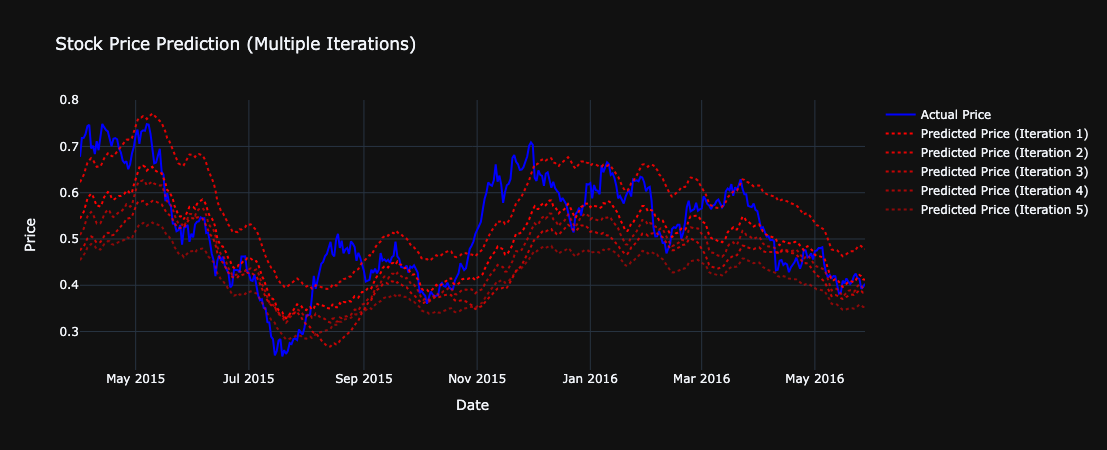